## EDA

В этом разделе загружаем специально подготовленный датасет и проводим анализ полученных данных 

### Import

In [247]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [248]:
# загружаем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.feature_extraction.text import CountVectorizer

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 8

# pymorphy2
!pip install -q pymorphy2
# !pip install -U pymorphy2-dicts-ru
!pip install -q stop_words

import pymorphy2
import re

In [249]:
PATH = 'drive/MyDrive/data/diplom_final/'
# PATH = ''

### Load the dataset

Данные для данной работы были выгружены из тикетной системы Jira и содержат обращения сотрудников(пользователей) компании по вопросам эксплуатации автоматизированных систем внутреннего технологического контура.

In [250]:
# загружаем данные
df = pd.read_csv(PATH+'data.csv', sep=',', error_bad_lines=False)
df.head()

,class,description
0,Fiji,Пропадают осевые В проекте Алматы периодическ...
1,Fiji,Проблемы с запуском фиджи День добрый При зап...
2,Fiji,зависает фиджи работать в фиджи не представля...
3,Fiji,Отображение дорожной сети в Фиджи Подскажите ...
4,Fiji,Атрибуты сущности ДГ При групповом редактиров...


### Look at the dataset

In [251]:
df.sample(5)

,class,description
3958,CRM отдел,Прошу перекинуть на меня Фирма Юлмарт интерне...
9390,Поддержка по отзывам,Отзыв в компанию в компанию Слетарь ру написа...
6534,Телекомунникация и связь,Запустить запись в праздничные дни Прошу запу...
1662,API,карта для мобильной версии поставили вашу кар...
6626,Телекомунникация и связь,Для Литвиновой Натальи Прошу взять в работу а...


In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11884 entries, 0 to 11883
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        11884 non-null  object
 1   description  11884 non-null  object
dtypes: object(2)
memory usage: 185.8+ KB


In [253]:
df.shape

(11884, 2)

In [254]:
classes = df['class'].nunique()
print(df['class'].unique())
print(f'Всего {classes} категорий классификации обращений')

['Fiji' 'API' 'Atlassian' 'Export buildman' 'CRM отдел'
 'Группа корректуры РМ' 'Телекомунникация и связь' 'IR' 'Группа Digital'
 'Поддержка по отзывам' 'Личный Кабинет' 'Поддержка товаров']
Всего 12 категорий классификации обращений


Датасет содержит обращения, прошедшие ручную классификацию первой линией технической поддержки. Для данной работы был подготовлен специальный датасет, содержащий обращения касающиеся 12-ти классов. По каждому классу было выбрано примерно по 1000 обращений.

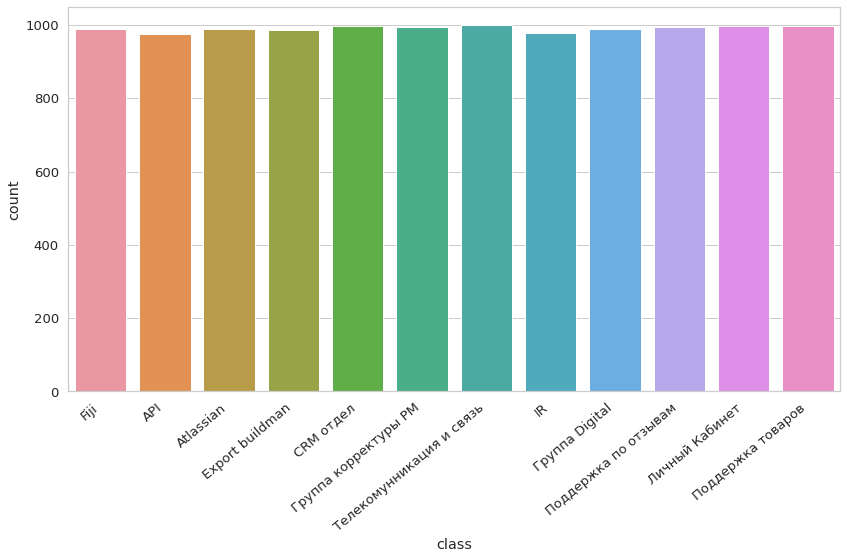

In [255]:
ax = sns.countplot(x="class", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Выборка является сбалансированной и содержит примерно равное количество обращений каждого из 12 классов.

### Анализ на уровне букв

In [256]:
df['description'].str.len().describe()

count    11884.000000
mean       341.153904
std        712.648196
min          6.000000
25%        134.750000
50%        229.000000
75%        370.000000
max      32415.000000
Name: description, dtype: float64

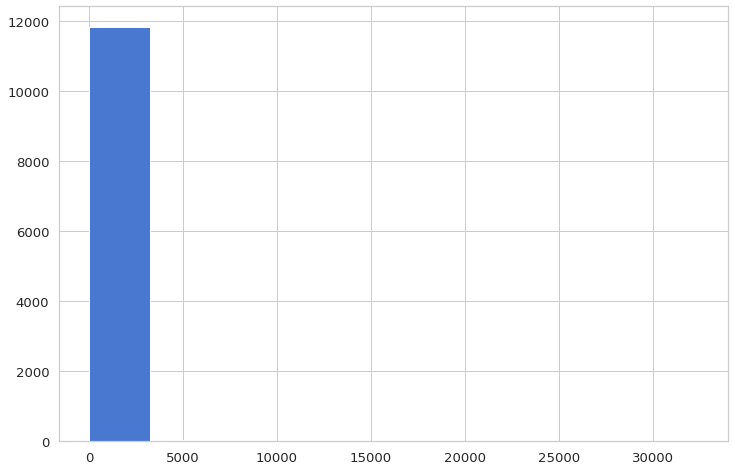

In [257]:
df['description'].str.len().hist()

### Анализ на уровне слов

In [258]:
df['description'].str.split().map(lambda x: len(x)).describe()

count    11884.000000
mean        51.425867
std         97.376548
min          1.000000
25%         20.000000
50%         35.000000
75%         57.000000
max       4039.000000
Name: description, dtype: float64

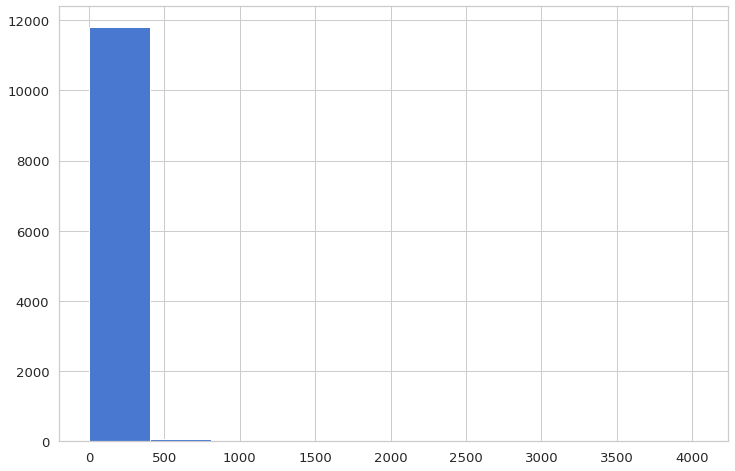

In [259]:
df['description'].str.split().map(lambda x: len(x)).hist()

### Средняя длина слов в предложениии

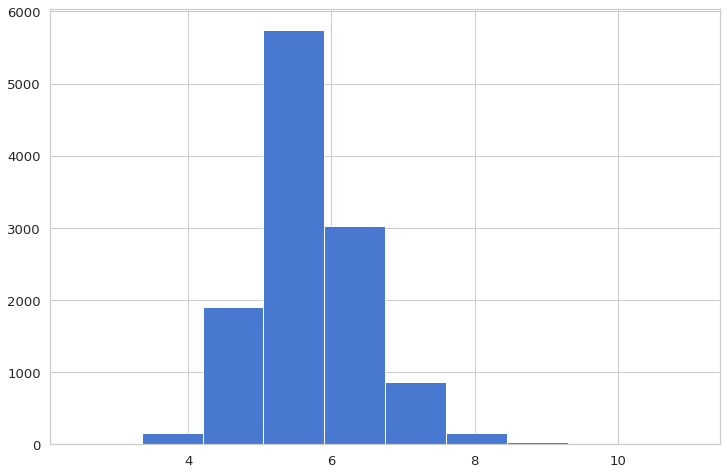

In [260]:
df['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

Анализ показывает что среднее обращение состоит из 51 слова (341 буквы). Типичное слово содержит 6-8 букв. Однако имеют место исключения: сверхдлинные обращения (4 тыс. слов) и сверхкоротткие (1 слово). Такие обращения не являются показательными. Их надо отфильтровать для избежания искажения результата.

###  Частотность слов входящих в список стоп-слов и встречающихся в обращениях:

In [261]:
from stop_words import get_stop_words
stop = get_stop_words('russian')
print(f'Загружено {len(stop)} стоп-слов')

Загружено 421 стоп-слов


In [262]:
def plot_top_stopwords_barchart(text):
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

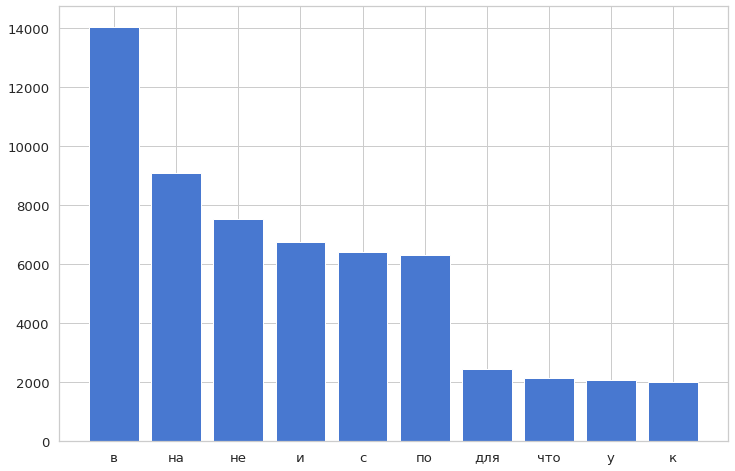

In [263]:
plot_top_stopwords_barchart(df['description'])

Стоп-слова присутствуют в наших описаниях, целесообразна очистка.

### Частотность слов, участвующих в описаниях и не входящих в список стоп-слов

In [264]:
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y = [], []
    for word,count in most[:30]:
        if (word.lower() not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

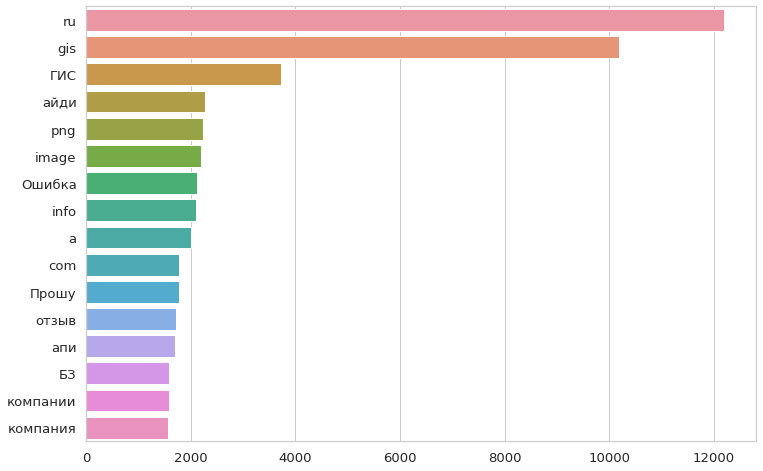

In [265]:
plot_top_non_stopwords_barchart(df['description'])

английские слова, сокращения, аббревиатуры ... (

In [266]:
morph = pymorphy2.MorphAnalyzer()

In [267]:
# переводим в нижний регистр
# проводим лематизацию
# удаляем все символы отличные от русских буквы
def clean_text01(txt):
    txt = str(txt).lower()
    txt = ' '.join(re.sub("[^а-я]", " ", word) for word in str(txt).split()) 
    txt = ' '.join(morph.parse(word)[0].normal_form for word in txt.split())    
    return txt

In [268]:
# преобразуем описания
df['description'] = df['description'].apply(lambda x: clean_text01(x))

In [269]:
# загружаем список стоп-слов
from stop_words import get_stop_words
stopwords = get_stop_words('russian')
print(f'В списке стоп-слов {len(stopwords)} слов') 

В списке стоп-слов 421 слов


In [270]:
# удаляем стоп-слова
def clean_text02(txt):
    txt = ' '.join(word for word in txt.split() if word not in stopwords)
    return txt

In [271]:
# преобразуем описания
df['description'] = df['description'].apply(lambda x: clean_text02(x))

определим топ N-gramm 

In [272]:
def plot_top_ngrams_barchart(text, n=2):
    stop = get_stop_words('russian')
    new = text.str.split()
    new=new.values.tolist()
    corpus = [word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(text,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

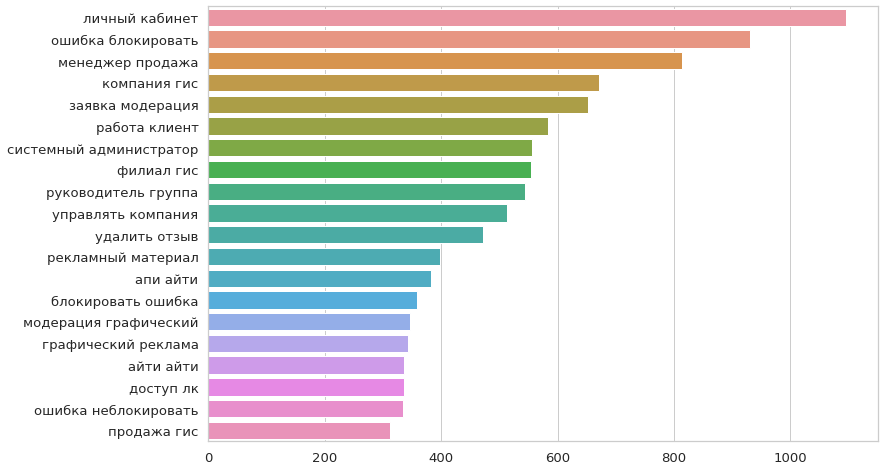

In [273]:
plot_top_ngrams_barchart(df['description'],2)

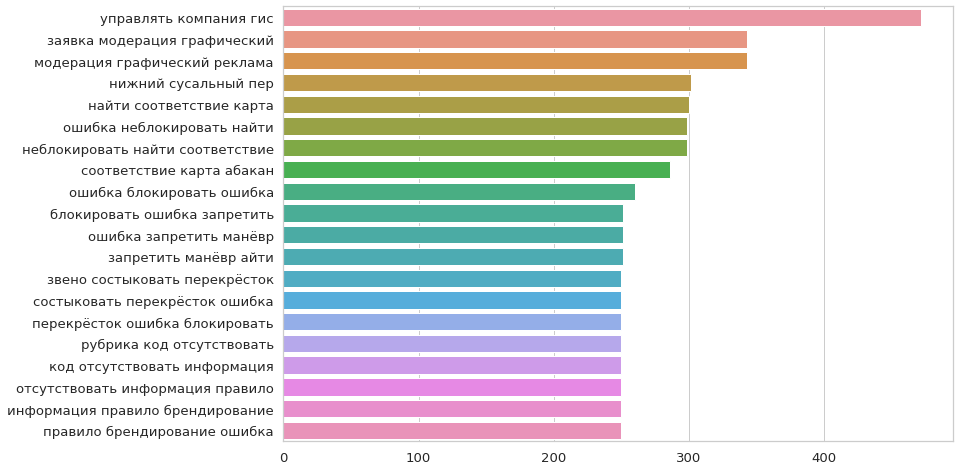

In [274]:
plot_top_ngrams_barchart(df['description'],3)

мы должны приложить некоторые усилия для очистки данных ...

In [275]:
df['description'] = df['description'].str.replace('управлять компания гис', '')
df['description'] = df['description'].str.replace('нижний сусальный пер', '')
df['description'] = df['description'].str.replace('менеджер продажа', '')
df['description'] = df['description'].str.replace('системный администратор', '')
df['description'] = df['description'].str.replace('филиал гис', '')
df['description'] = df['description'].str.replace('руководитель группа', '')
df['description'] = df['description'].str.replace('невский пр этаж', '')
df['description'] = df['description'].str.replace('айти', '')
df['description'] = df['description'].str.replace('бз', '')
df['description'] = df['description'].str.replace('сеть восток запад', '')
df['description'] = df['description'].str.replace('специалист работа клиент', '')
df['description'] = df['description'].str.replace('ул щербанева этаж', '')
df['description'] = df['description'].str.replace('апи апи апи', '')
df['description'] = df['description'].str.replace('апи апи', 'апи')
df['description'] = df['description'].str.replace('франчайзи сеть', '')
df['description'] = df['description'].str.replace('компания гис', '')
df['description'] = df['description'].str.replace('продажа гис', '')
df['description'] = df['description'].str.replace('день добрый', '')
df['description'] = df['description'].str.replace('подскажите', '')
df['description'] = df['description'].str.replace('просьба', '')
df['description'] = df['description'].str.replace('ошибка', '')
df['description'] = df['description'].str.replace('просить', '')
df['description'] = df['description'].str.replace('гис', '')


In [276]:
# удаляем все слова короче 2 символов
def clean_text03(txt):
    txt = ' '.join(word for word in txt.split() if len(word)>1) 
    return txt

In [277]:
# преобразуем описания, ограничиваем длину слов участвующих в описании
df['description'] = df['description'].apply(lambda x: clean_text03(x))

In [278]:
# убираем пустые строки
df['description'].replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11866 entries, 0 to 11883
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        11866 non-null  object
 1   description  11866 non-null  object
dtypes: object(2)
memory usage: 278.1+ KB


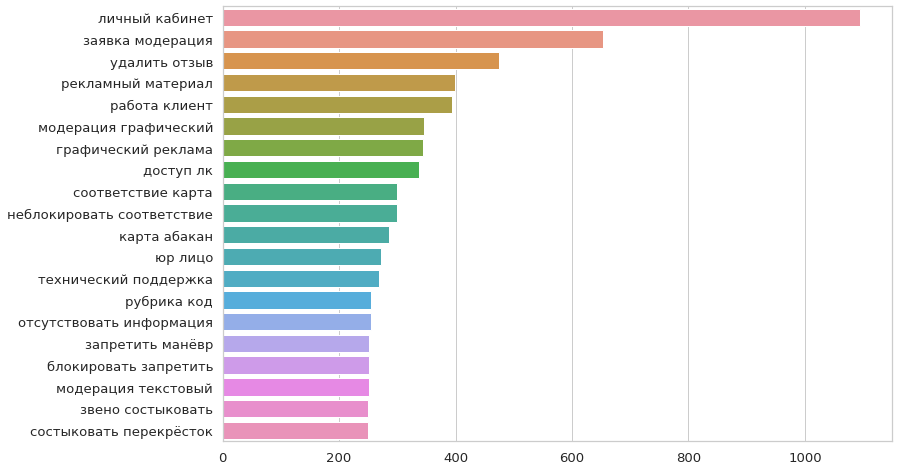

In [279]:
# ревизия топ n-gramm
plot_top_ngrams_barchart(df['description'],2)

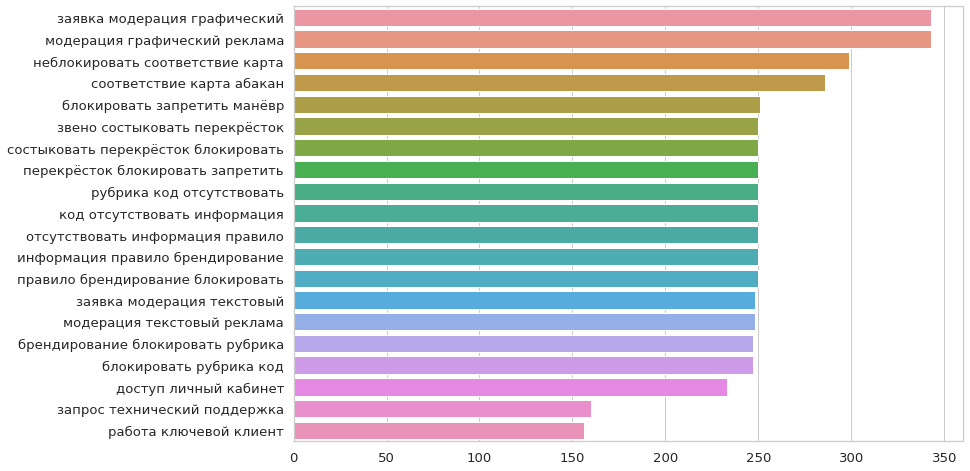

In [280]:
# ревизия топ n-gramm
plot_top_ngrams_barchart(df['description'],3)

Так как датасет содержит реальные данные из тикетной системы, обращения содержат персонифицирующую информацию: ФИО сотрудника, город его локации. Данная информация никак не повлияет на решение поставленной задачи и должна быть удалена.

Из внешних источников были загружены открытые база имен, фамилий, отчеств используемые на территории России, а также список российских городов.

In [281]:
# загружаем внешние базы с данными по городам, именам, фамилиям
city = pd.read_csv(PATH+'city.csv', header=None, sep=';')
name = pd.read_csv(PATH+'name.csv', header=None, sep=';')
surname = pd.read_csv(PATH+'surname.csv', header=None, sep=';')
patron = pd.read_csv(PATH+'patron.csv', header=None, sep=';')
city[0]=city[0].apply(lambda x: x.lower())
name[0]=name[0].apply(lambda x: x.lower())
surname[0]=surname[0].apply(lambda x: x.lower())
patron[0]=patron[0].apply(lambda x: x.lower())
info_id_0 = name[0].to_list()
info_id_1 = city[0].to_list()
info_id_2 = surname[0].to_list()
info_id_3 = patron[0].to_list()

In [282]:
# удаляем имена, фамилии, отчества, названия городов, стоп-слова
def clean_text04(txt):
    txt = ' '.join(word for word in txt.split() if word not in info_id_0)
    txt = ' '.join(word for word in txt.split() if word not in info_id_1)
    txt = ' '.join(word for word in txt.split() if word not in info_id_2)
    txt = ' '.join(word for word in txt.split() if word not in info_id_3)
    return txt

In [283]:
# преобразуем описания
df['description'] = df['description'].apply(lambda x: clean_text04(x))

In [284]:
df.head()

,class,description
0,Fiji,пропадать осевой проект алматы периодически ис...
1,Fiji,проблема запуск запуск крашиться сигнатура про...
2,Fiji,зависать работать представляться возможный заг...
3,Fiji,отображение сеть подсказать убрать выделяться ...
4,Fiji,атрибут сущность дг групповой редактирование г...


In [285]:
# удаляем дублирующие записи
df.drop_duplicates(subset='description', keep='first', inplace=True)

In [286]:
# создаем новый признак - количество слов в описании
df['numbers'] = df['description'].apply(lambda x: len(x.split()))

In [287]:
# убираем самые короткие (малоинформативные) описания
df = df[(df['numbers'] > 3)] 

In [288]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9811 entries, 0 to 11883
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        9811 non-null   object
 1   description  9811 non-null   object
 2   numbers      9811 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 306.6+ KB


In [289]:
df['description'].str.split().map(lambda x: len(x)).describe()

count    9811.000000
mean       19.895627
std        33.980685
min         4.000000
25%         9.000000
50%        14.000000
75%        22.000000
max      1769.000000
Name: description, dtype: float64

Оценим частотность слов в обращеннях различных классов

Распределение слов в классе: Поддержка товаров


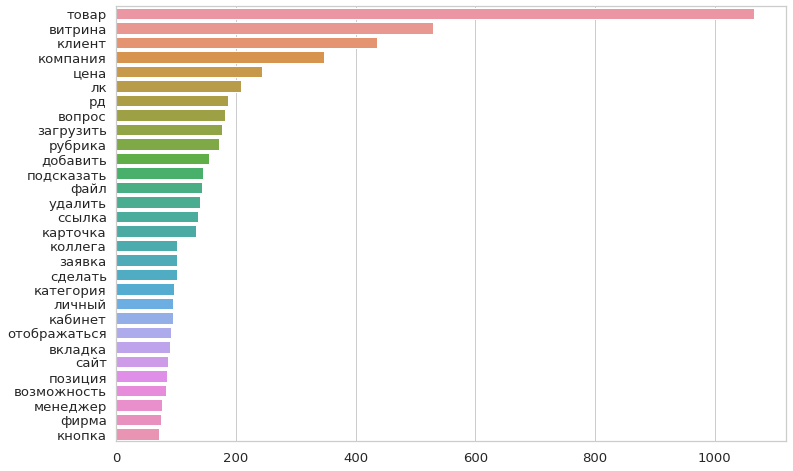

In [325]:
# список классов
cat = df['class'].unique()
i=0
print(f'Распределение слов в классе: {cat[i]}')
dfc = df[df['class'] == cat[i]]
plot_top_non_stopwords_barchart(dfc['description'])

Распределение слов в классе: Fiji


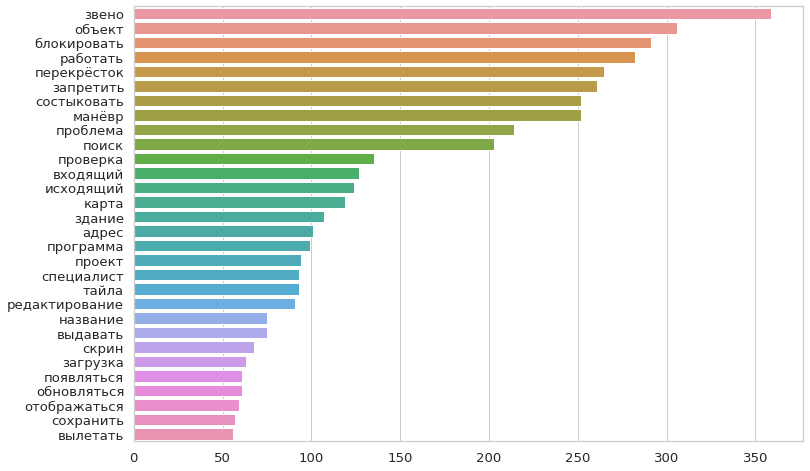

In [313]:
i += 1
print(f'Распределение слов в классе: {cat[i]}')
dfc = df[df['class'] == cat[i]]
plot_top_non_stopwords_barchart(dfc['description'])

Распределение слов в классе: Export buildman


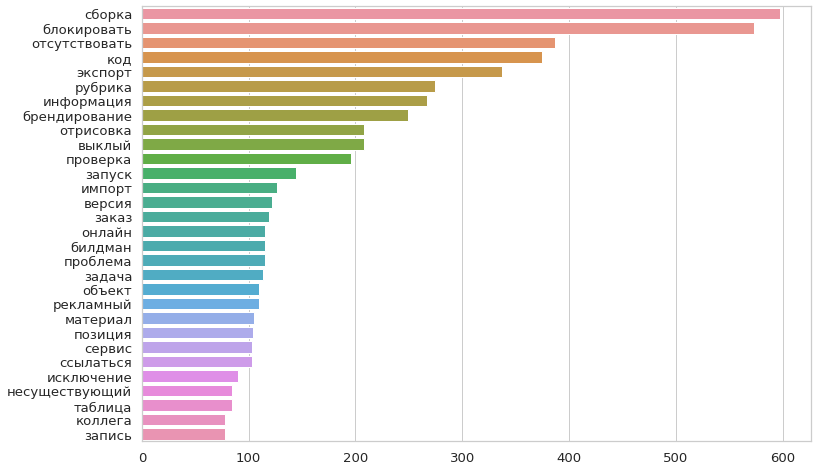

In [314]:
i +=1
print(f'Распределение слов в классе: {cat[i]}')
dfc = df[df['class'] == cat[i]]
plot_top_non_stopwords_barchart(dfc['description'])

Распределение слов в классе: API


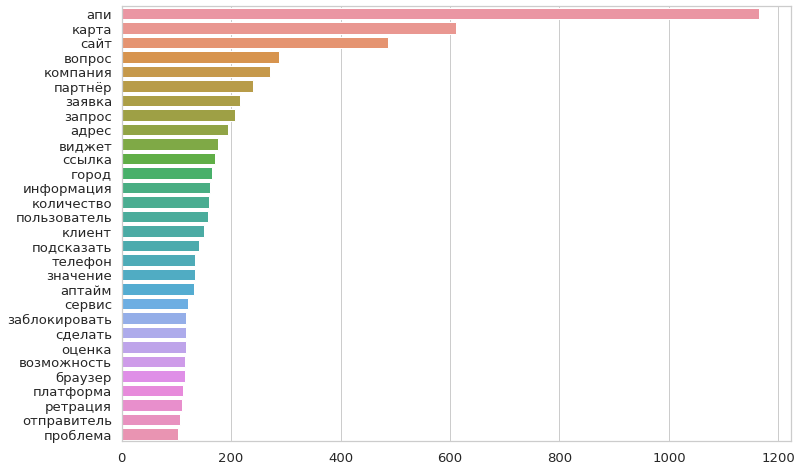

In [315]:
i +=1
print(f'Распределение слов в классе: {cat[i]}')
dfc = df[df['class'] == cat[i]]
plot_top_non_stopwords_barchart(dfc['description'])

Распределение слов в классе: Личный Кабинет


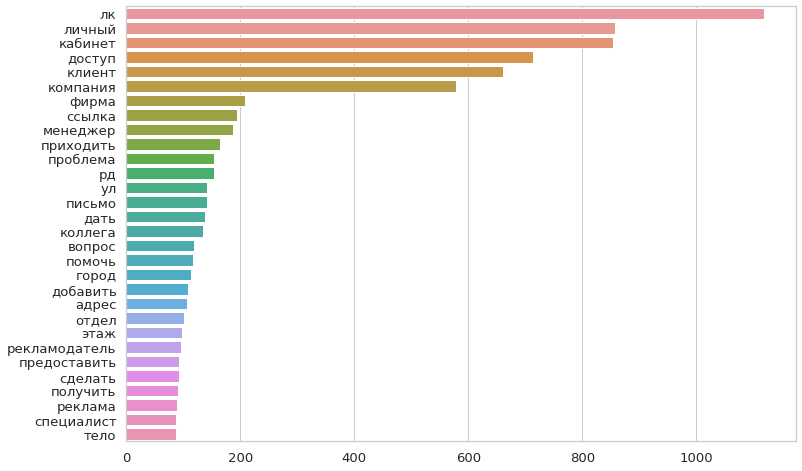

In [316]:
i +=1
print(f'Распределение слов в классе: {cat[i]}')
dfc = df[df['class'] == cat[i]]
plot_top_non_stopwords_barchart(dfc['description'])

Распределение слов в классе: Группа корректуры РМ


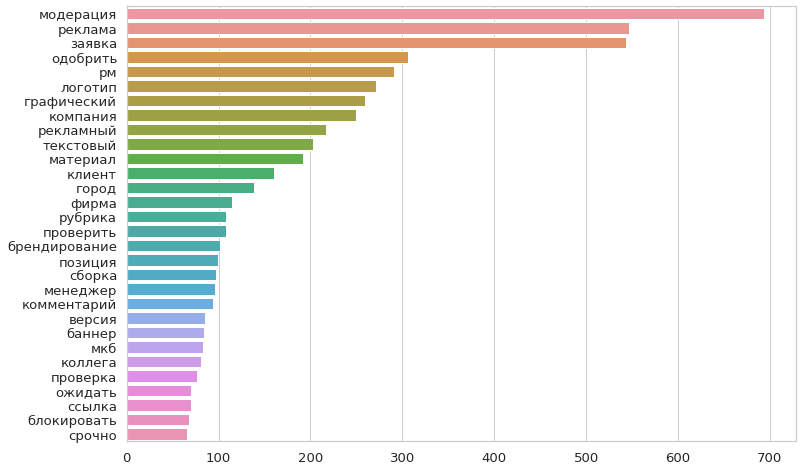

In [317]:
i +=1
print(f'Распределение слов в классе: {cat[i]}')
dfc = df[df['class'] == cat[i]]
plot_top_non_stopwords_barchart(dfc['description'])

Распределение слов в классе: Поддержка по отзывам


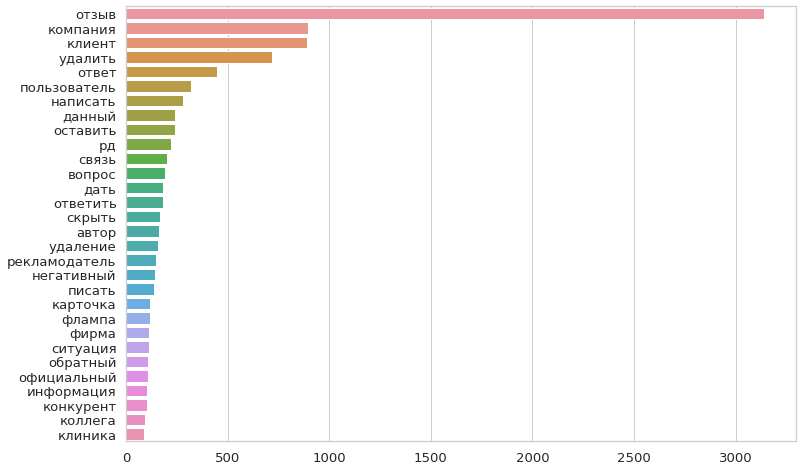

In [318]:
i +=1
print(f'Распределение слов в классе: {cat[i]}')
dfc = df[df['class'] == cat[i]]
plot_top_non_stopwords_barchart(dfc['description'])

Распределение слов в классе: Группа Digital


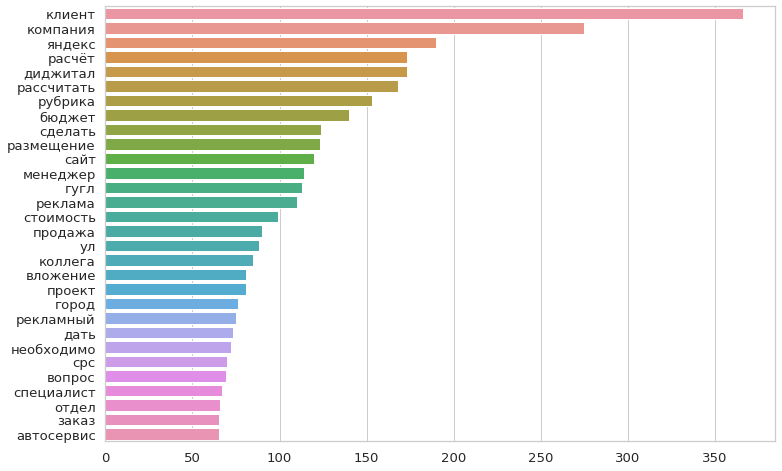

In [319]:
i +=1
print(f'Распределение слов в классе: {cat[i]}')
dfc = df[df['class'] == cat[i]]
plot_top_non_stopwords_barchart(dfc['description'])

Распределение слов в классе: Atlassian


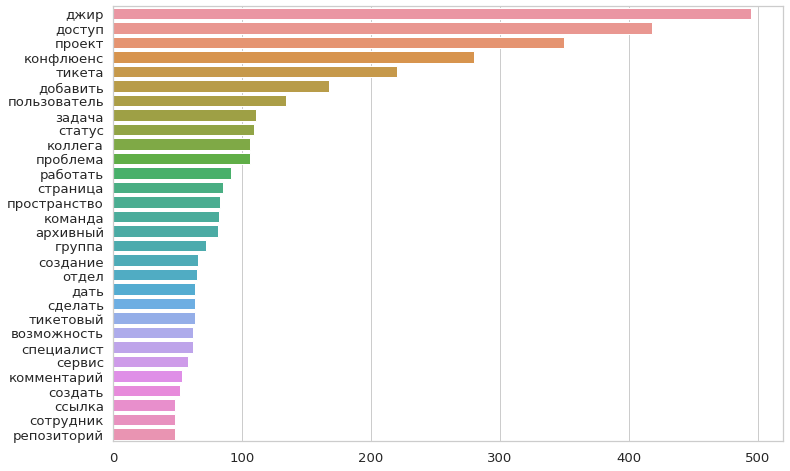

In [320]:
i +=1
print(f'Распределение слов в классе: {cat[i]}')
dfc = df[df['class'] == cat[i]]
plot_top_non_stopwords_barchart(dfc['description'])

Распределение слов в классе: Телекомунникация и связь


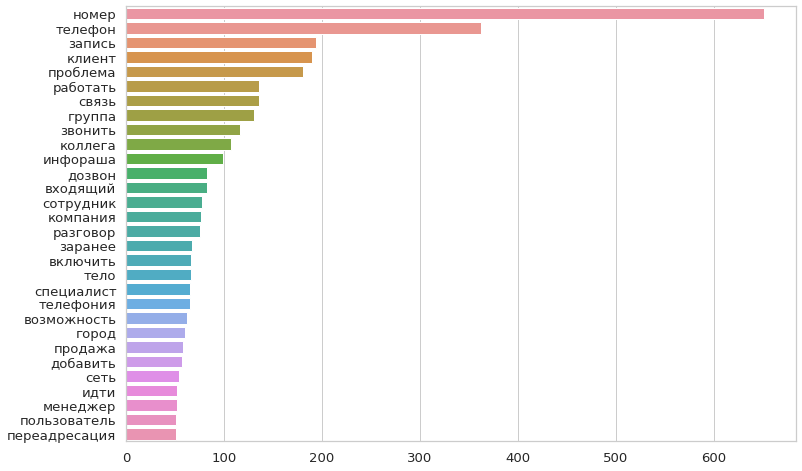

In [321]:
i +=1
print(f'Распределение слов в классе: {cat[i]}')
dfc = df[df['class'] == cat[i]]
plot_top_non_stopwords_barchart(dfc['description'])

Распределение слов в классе: IR


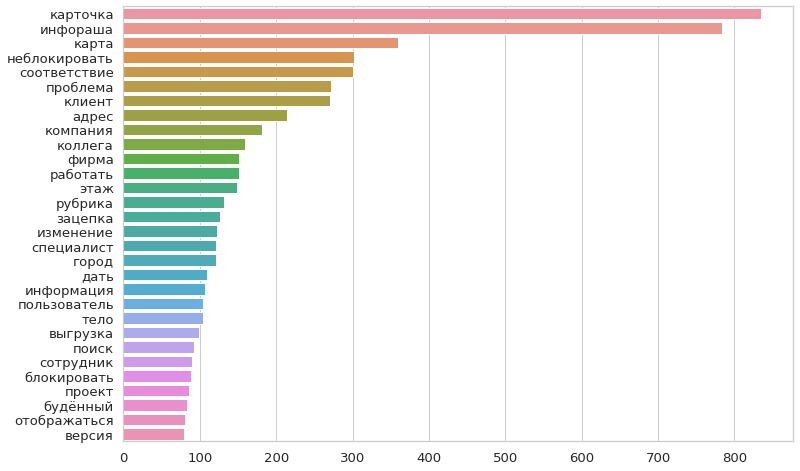

In [322]:
i +=1
print(f'Распределение слов в классе: {cat[i]}')
dfc = df[df['class'] == cat[i]]
plot_top_non_stopwords_barchart(dfc['description'])

Распределение слов в классе: CRM отдел


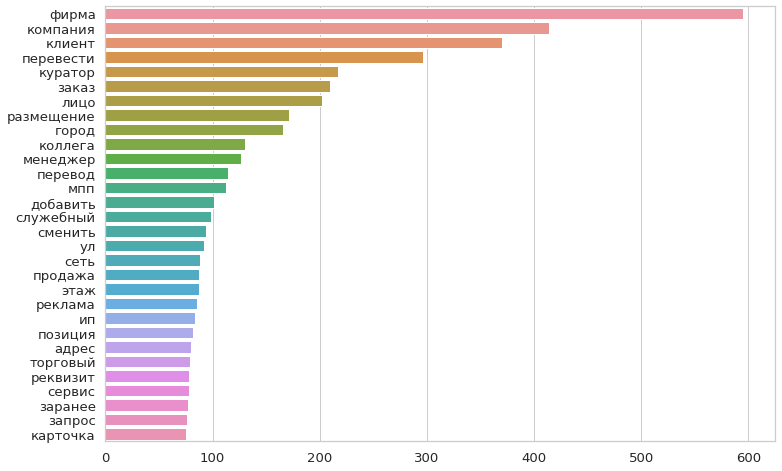

In [323]:
i +=1
print(f'Распределение слов в классе: {cat[i]}')
dfc = df[df['class'] == cat[i]]
plot_top_non_stopwords_barchart(dfc['description'])

Не смотря на то что каждый класс имеет характерные отличия в части наиболее частотного словарного комплекта, говорить об абсолютной уникальности к сожалению нельзя. Поэтому ... без ML решения в данной задаче мы не обойдемся.

### Для наглядности построим облако слова (WorldCloud) оставшихся в описаниях.

In [303]:
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('punkt')
nltk.download('wordnet')

def plot_wordcloud(text):

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


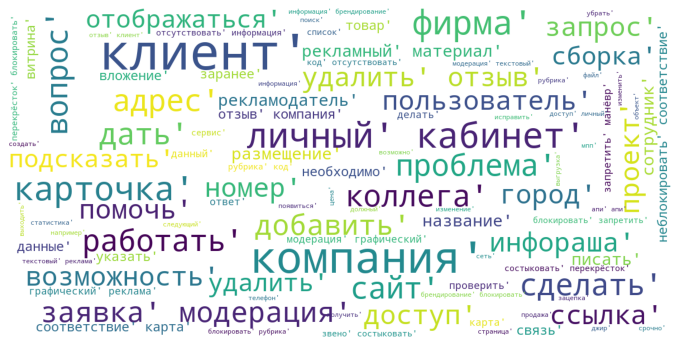

In [304]:
plot_wordcloud(df['description'])

Очищенный датасет сохраняем для использования на последующих этапах.

In [305]:
#  перемешаем записи в датасете для обеспечения однородности 
df = df.sample(frac=1).reset_index(drop=True)

In [306]:
df.to_csv('data_prepare.csv', encoding='utf-8', index=False)